# Anomaly Detection - Henry Hub Spot Price Dataset

Inspiration from https://medium.com/swlh/time-series-anomaly-detection-with-lstm-autoencoders-7bac1305e713

In [12]:
from utils.data.henryhub_gas_spotprice import data_reader 
from utils.data.henryhub_gas_spotprice import data_plot 
from utils.data import data_util
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [13]:
reader = data_reader.ReadData()
dataset = reader.load_data()

Reading:  /lhome/ruocco/anomaly-detection-gnn/anomaly_detection/utils/data/henryhub_gas_spotprice/dataset/Henry_Hub_Natural_Gas_Spot_Price.csv
....Dropped Missing value row....
Rechecking Missing values: price    0
dtype: int64
(6035, 1)


In [14]:
dataset = dataset.loc['2000-01-01':,['price']] 
dataset = dataset.loc[dataset.index<'2020-09-01']

Historical Spot price visualization:


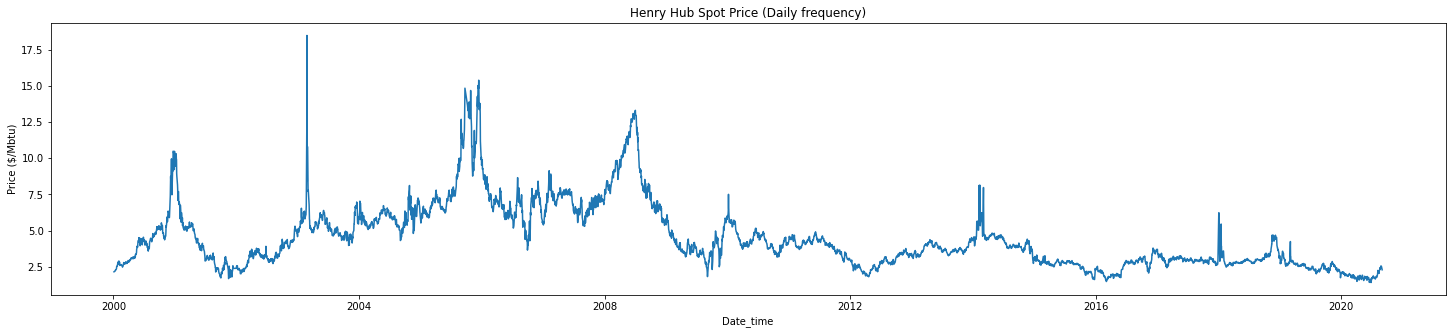

In [15]:
data_plot.plot(dataset)

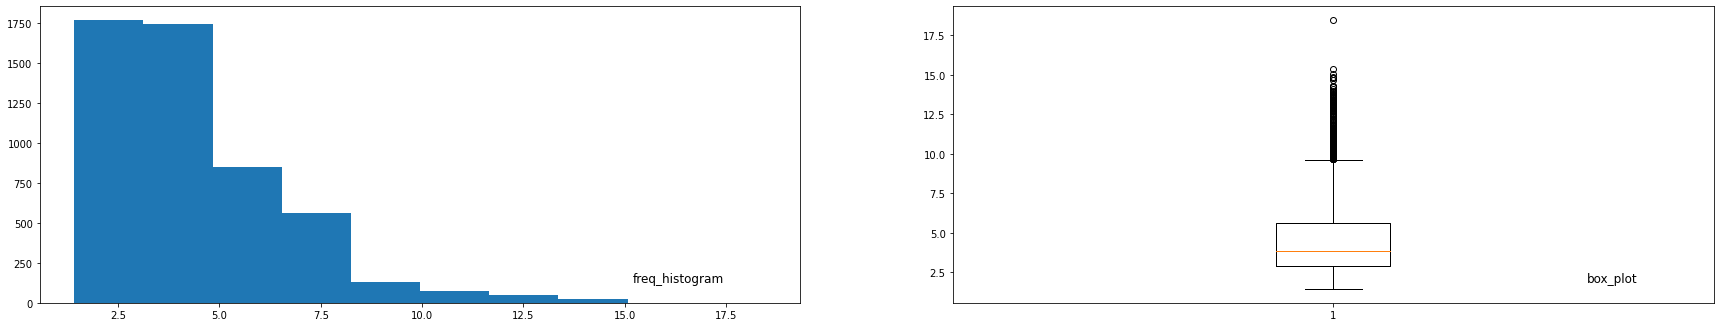

In [16]:
data_util.vis_behaviour(dataset, dataset.columns[0])

In [17]:
data_util.describe(dataset)

        count     mean       std   min   25%   50%   75%    max
price  5196.0  4.46173  2.205866  1.42  2.88  3.86  5.59  18.48


In [18]:
dataset.index.min(), dataset.index.max()

(Timestamp('2000-01-04 00:00:00'), Timestamp('2020-08-31 00:00:00'))

In [19]:
from sklearn import preprocessing 
scaler = preprocessing.RobustScaler(quantile_range=(25, 75))
train, test = data_util.split(dataset, dataset.columns[0], scaler=scaler, test_size=0.05)

Train_shape:  (4936, 1)
Test_shape:  (260, 1)
Data Standardization with  RobustScaler(quantile_range=(25, 75))


In [20]:
col_name = dataset.columns[0]
n_steps = 30
X_train, y_train = data_util.create_dataset(train[[col_name]], train[col_name], n_steps)
X_test, y_test = data_util.create_dataset(test[[col_name]], test[col_name], n_steps)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print("-------------------")

X_train shape: (4906, 30, 1)
X_test shape: (230, 30, 1)
y_train shape: (4906,)
y_test shape: (230,)
-------------------


In [24]:
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
units = 64
dropout = 0.2
loss = 'mae'
optimizer = 'adam'

from tensorflow import keras
from models import keras_lstm_ae
model = keras_lstm_ae.create_lstm_ae(input_shape=(n_timesteps, n_features), dropout=dropout, units=units)
#model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.compile(loss = loss, optimizer = optimizer)
model.summary()

Model: "lstm_ae_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30, 1)]           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 30, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 1)           

In [25]:
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')], shuffle=False) #X_train

Epoch 1/60
138/138 [==============================] - 6s 26ms/step - loss: 0.2031 - val_loss: 0.0773
Epoch 2/60
138/138 [==============================] - 3s 22ms/step - loss: 0.1388 - val_loss: 0.0734
Epoch 3/60
138/138 [==============================] - 3s 23ms/step - loss: 0.1226 - val_loss: 0.0745
Epoch 4/60
138/138 [==============================] - 3s 22ms/step - loss: 0.1129 - val_loss: 0.0617
Epoch 5/60
138/138 [==============================] - 3s 22ms/step - loss: 0.1014 - val_loss: 0.0587
Epoch 6/60
138/138 [==============================] - 3s 22ms/step - loss: 0.0998 - val_loss: 0.0613
Epoch 7/60
138/138 [==============================] - 3s 21ms/step - loss: 0.1020 - val_loss: 0.0575
Epoch 8/60
138/138 [==============================] - 3s 21ms/step - loss: 0.0939 - val_loss: 0.0537
Epoch 9/60
138/138 [==============================] - 3s 22ms/step - loss: 0.0900 - val_loss: 0.0507
Epoch 10/60
138/138 [==============================] - 3s 23ms/step - loss: 0.0914 - val_lo

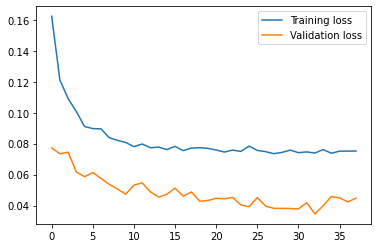

In [26]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='Training loss')
pyplot.plot(history.history['val_loss'], label='Validation loss')
pyplot.legend();

In [27]:
model.evaluate(X_test, y_test)


8/8 [==============================] - 0s 5ms/step - loss: 0.0650


0.06498342752456665

Training loss:  0.17645250552712244

Reconstruction error threshold: 2.814554640044662


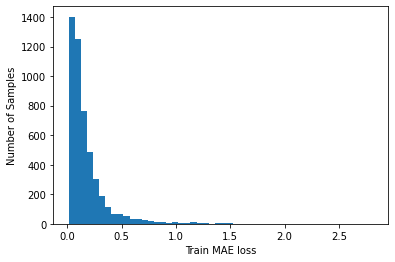

In [28]:
# CALCULATING THRESHOLD (WAY1)

import numpy as np
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
avg_loss = train_mae_loss.mean()
print("Training loss: ", avg_loss); print()

pyplot.hist(train_mae_loss, bins=50)
pyplot.xlabel('Train MAE loss')
pyplot.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

In [29]:
import math
import sklearn
# MAE on the test data:
X_test_pred = model.predict(X_test)
print('Predict shape (X_test_pred):', X_test_pred.shape); print();
mae = np.mean(np.abs(X_test_pred - X_test), axis=1)
# reshaping prediction
pred = X_test_pred.reshape((X_test_pred.shape[0] * X_test_pred.shape[1]), X_test_pred.shape[2])
print('Prediction:', pred.shape); print();
print('Test data shape (X_test):', X_test.shape); print();
# reshaping test data
X_test_reshape = X_test.reshape((X_test.shape[0] * X_test.shape[1]), X_test.shape[2])
print('Test data (X_test_reshape):', X_test_reshape.shape); print();
# error computation
errors = X_test_reshape - pred
print('Error:', errors.shape); print();
# rmse on test data
RMSE = math.sqrt(sklearn.metrics.mean_squared_error(X_test_reshape, pred))
print('Test RMSE: %.3f' % RMSE);

Predict shape (X_test_pred): (230, 30, 1)

Prediction: (6900, 1)

Test data shape (X_test): (230, 30, 1)

Test data (X_test_reshape): (6900, 1)

Error: (6900, 1)

Test RMSE: 0.104


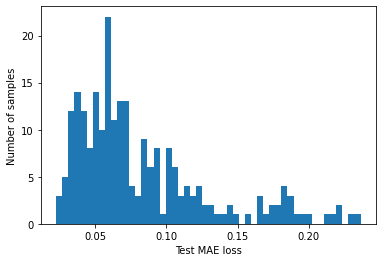

In [30]:
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

pyplot.hist(test_mae_loss, bins=50)
pyplot.xlabel('Test MAE loss')
pyplot.ylabel('Number of samples');

In [31]:
# CALCULATING THRESHOLD (WAY1)
dist = np.linalg.norm(X_test_reshape - pred, axis=1)
scores = dist.copy();
print("Score", scores.shape)
scores.sort()
cut_off = int(0.80*len(scores))
print("cut_off value: ", cut_off)
threshold = scores[cut_off]
print(f'Threshold: {threshold}')

Score (6900,)
cut_off value:  5520
Threshold: 0.12599043811701682


In [32]:
test_score_df = pd.DataFrame(test[n_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df[dataset.columns[0]] = test[n_steps:][dataset.columns[0]]


In [33]:
test_score_df.tail()


,price,loss,threshold,anomaly
Day,,,,
2020-08-25,-0.516245,0.236436,0.12599,True
2020-08-26,-0.523466,0.216322,0.12599,True
2020-08-27,-0.523466,0.201050,0.12599,True
2020-08-28,-0.545126,0.192427,0.12599,True
2020-08-31,-0.602888,0.164958,0.12599,True


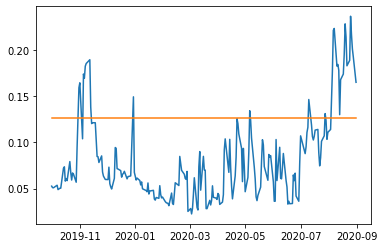

In [34]:
pyplot.plot(test_score_df['loss'])
pyplot.plot(test_score_df['threshold'])

In [35]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.head()

,price,loss,threshold,anomaly
Day,,,,
2019-10-30,-0.454874,0.127754,0.12599,True
2019-10-31,-0.447653,0.159028,0.12599,True
2019-11-01,-0.516245,0.164404,0.12599,True
2019-11-05,-0.433213,0.173917,0.12599,True
2019-11-06,-0.415162,0.169378,0.12599,True


In [36]:
test_score_df

,price,loss,threshold,anomaly
Day,,,,
2019-10-01,-0.581227,0.052580,0.12599,False
2019-10-02,-0.581227,0.050960,0.12599,False
2019-10-03,-0.599278,0.050842,0.12599,False
2019-10-04,-0.620939,0.051534,0.12599,False
2019-10-07,-0.581227,0.053566,0.12599,False
...,...,...,...,...
2020-08-25,-0.516245,0.236436,0.12599,True
2020-08-26,-0.523466,0.216322,0.12599,True
2020-08-27,-0.523466,0.201050,0.12599,True


In [37]:
anomalies

,price,loss,threshold,anomaly
Day,,,,
2019-10-30,-0.454874,0.127754,0.12599,True
2019-10-31,-0.447653,0.159028,0.12599,True
2019-11-01,-0.516245,0.164404,0.12599,True
2019-11-05,-0.433213,0.173917,0.12599,True
2019-11-06,-0.415162,0.169378,0.12599,True
2019-11-07,-0.407942,0.182372,0.12599,True
2019-11-08,-0.397112,0.185261,0.12599,True
2019-11-12,-0.451264,0.189375,0.12599,True
2019-11-13,-0.472924,0.138136,0.12599,True


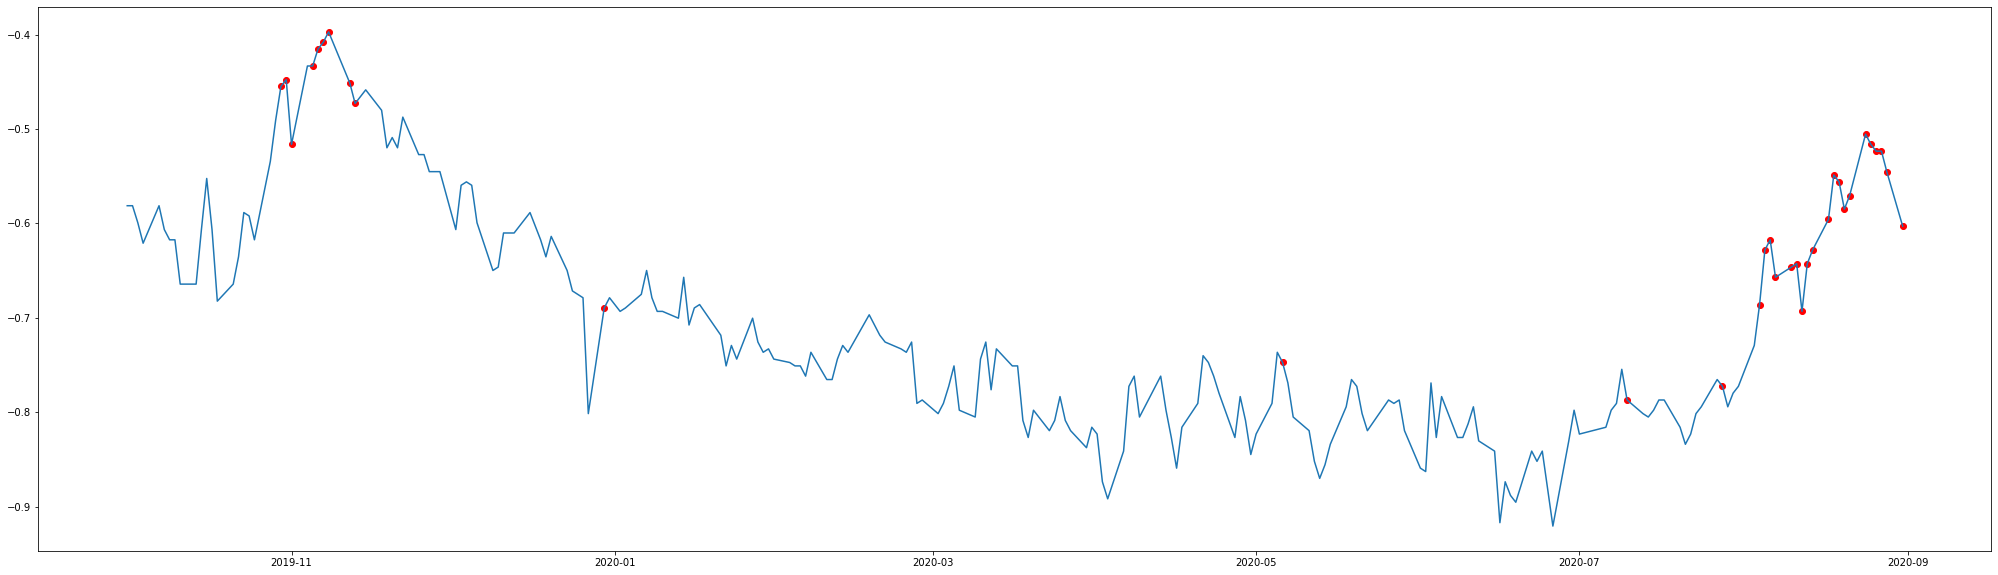

In [38]:
pyplot.figure(figsize=(35,10))
pyplot.plot(test_score_df.index, (test_score_df[dataset.columns[0]]))
pyplot.scatter(anomalies.index, (anomalies[dataset.columns[0]]), marker='o', color="red")

X_test_reshaped: (6900, 1)

Prediction: (6900, 1)



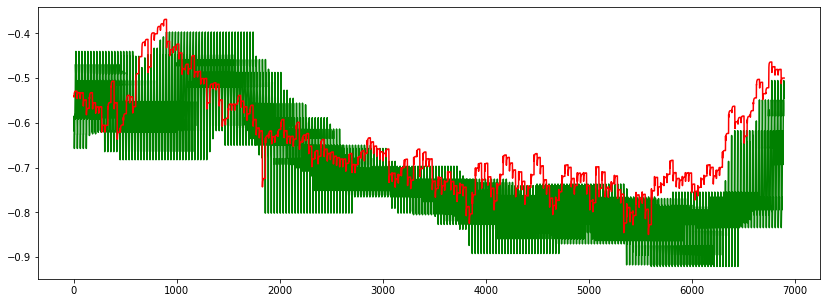

In [40]:
X_test_reshaped = X_test.reshape((X_test.shape[0] * X_test.shape[1]), X_test.shape[2])
print('X_test_reshaped:', X_test_reshaped.shape); print();
print('Prediction:', pred.shape); print();

pyplot.figure(figsize=(14,5))
pyplot.plot(X_test_reshaped, color = "green")
pyplot.plot(pred, color = "red")
